#### Weight of Evidence 

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default).

- WoE will be 0 if the $P(Goods) / P(Bads) = 1$, that is, if the outcome is random for that group.
- If $P(Bads) > P(Goods)$ the odds ratio will be $< 1$ and,
- WoE will be $< 0$ if, $P(Goods) > P(Bads).$

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., $ln(P(Goods)/P(Bads))$. Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

**The WoE transformation has three advantages:**

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

**The WoE also has a limitation:**

- Prone to cause over-fitting

For more details follow this [article](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#Steps-of-Calculating-WOE)  and this [article](https://blogs.oracle.com/r/computing-weight-of-evidence-woe-and-information-value-iv).

Dataset: Titanic

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

In [2]:
use_columns = ['cabin', 'sex', 'embarked', 'survived']

data = pd.read_csv('../datasets/titanic.csv', usecols=use_columns)
data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# let's remove observations with na in embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [4]:
# lets extract the first letter form cabin 

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [7]:
# let's have a look at how many labels and values each variable has
for col in data.columns:
    print(f"{col}: \n{data[col].value_counts()}")


survived: 
0    808
1    498
Name: survived, dtype: int64
sex: 
male      842
female    464
Name: sex, dtype: int64
cabin: 
n    1014
C      94
B      63
D      46
E      41
A      22
F      21
G       5
Name: cabin, dtype: int64
embarked: 
S    913
C    270
Q    123
Name: embarked, dtype: int64


**Encoding important**

We select calculate the woe using the train set, and then use those mappings in the test set.

Note that in the pandas implementation, we need to keep the target in the training set

In [8]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0
)
print(f"Train: {X_train.shape}, test: {X_test.shape}")

Train: (914, 4), test: (392, 4)


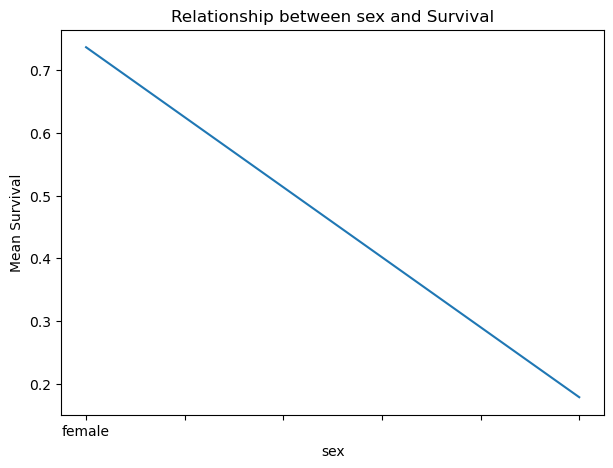

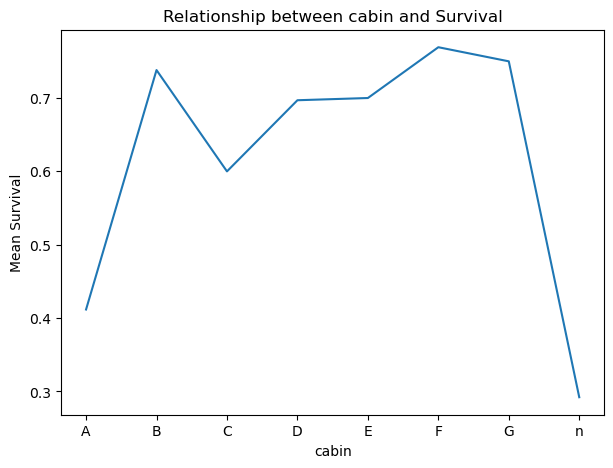

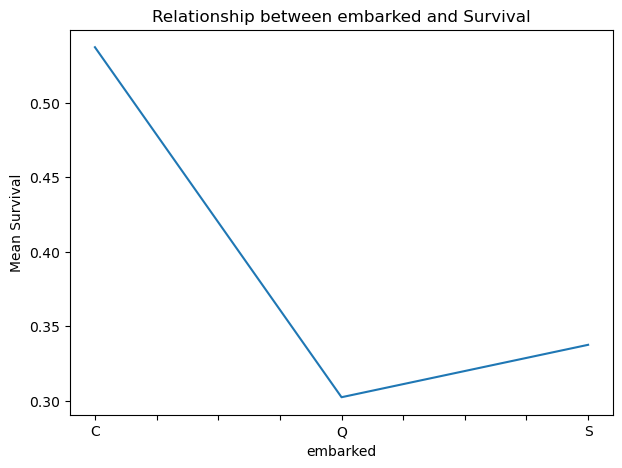

In [10]:
# let's explore the relationship of the categories with the target

for var in data.columns:
    if not var == 'survived':
        fig = plt.figure(figsize=(7,5))
        fig = X_train.groupby([var])['survived'].mean().plot()
        fig.set_title('Relationship between {} and Survival'.format(var))
        fig.set_ylabel('Mean Survival')
        plt.show()

**Weight of Evidence with pandas**

We need to store the mappings separately if planning to use the model in production.

In [21]:
total_died, total_survived = X_train['survived'].value_counts()

# lets create flag for who died 
X_train['died'] = np.where(X_train['survived'] == 0, 1,0)

X_train.head()


,cabin,sex,embarked,survived,died
843,n,male,S,0,1
869,n,male,S,0,1
430,n,female,S,1,0
481,n,female,C,1,0
1308,n,male,S,0,1


In [22]:
survived_prob = X_train.groupby(['cabin'])['survived'].sum() / total_survived
died_prob = X_train.groupby(['cabin'])['died'].sum() / total_died

print(f"Survived prob: {survived_prob} \n Died prob: {died_prob}")


Survived prob: cabin
A    0.020408
B    0.090379
C    0.122449
D    0.067055
E    0.061224
F    0.029155
G    0.008746
n    0.600583
Name: survived, dtype: float64 
 Died prob: cabin
A    0.017513
B    0.019264
C    0.049037
D    0.017513
E    0.015762
F    0.005254
G    0.001751
n    0.873905
Name: died, dtype: float64


In [25]:
#  now let's combine those 2 series in a dataframe and calculate the
# WoE
# let's concatenate the series in a dataframe
prob_df = pd.concat([survived_prob, died_prob], axis=1)
prob_df

,survived,died
cabin,,
A,0.020408,0.017513
B,0.090379,0.019264
C,0.122449,0.049037
D,0.067055,0.017513
E,0.061224,0.015762
F,0.029155,0.005254
G,0.008746,0.001751
n,0.600583,0.873905


In [29]:
# lets compute the woe
prob_df['woe'] = np.log(prob_df['survived']/ prob_df['died'])
prob_df

,survived,died,wpe,woe
cabin,,,,
A,0.020408,0.017513,0.152984,0.152984
B,0.090379,0.019264,1.545751,1.545751
C,0.122449,0.049037,0.915124,0.915124
D,0.067055,0.017513,1.342568,1.342568
E,0.061224,0.015762,1.356957,1.356957
F,0.029155,0.005254,1.713632,1.713632
G,0.008746,0.001751,1.608271,1.608271
n,0.600583,0.873905,-0.375071,-0.375071


In [30]:
# and now let's capture the woe in a dictionary

ordered_labels = prob_df['woe'].to_dict()

ordered_labels

{'A': 0.1529838185513379,
 'B': 1.545750694176846,
 'C': 0.9151238705982346,
 'D': 1.3425678854251744,
 'E': 1.356956622877274,
 'F': 1.7136315668160063,
 'G': 1.60827105115818,
 'n': -0.37507116447186734}

In [33]:
def find_category_mappings(df, variable, target):
    copy_df = df.copy()

    total_died, total_survived = copy_df[target].value_counts()
    # lets create flag for who died 
    copy_df['died'] = np.where(copy_df[target] == 0, 1,0)

    survived_prob = copy_df.groupby([variable])[target].sum() / total_survived
    died_prob = copy_df.groupby([variable])['died'].sum() / total_died

    prob_df = pd.concat([survived_prob, died_prob], axis=1)
    prob_df['woe'] = np.log(prob_df[target]/ prob_df['died'])
    del copy_df
    return prob_df['woe'].to_dict()


def integer_encoding(train, test, variable, ordinal_mapping):
    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)
    

In [34]:
# and now we run a loop over the remaining categorical variables

for variable in data.columns:
    if not variable == 'survived':
        mappings = find_category_mappings(X_train, variable, 'survived')
        integer_encoding(X_train, X_test, variable, mappings)

In [36]:
X_train.head()

,cabin,sex,embarked,survived,died
843,-0.375071,-1.013111,-0.164796,0,1
869,-0.375071,-1.013111,-0.164796,0,1
430,-0.375071,1.535068,-0.164796,1,0
481,-0.375071,1.535068,0.658871,1,0
1308,-0.375071,-1.013111,-0.164796,0,1


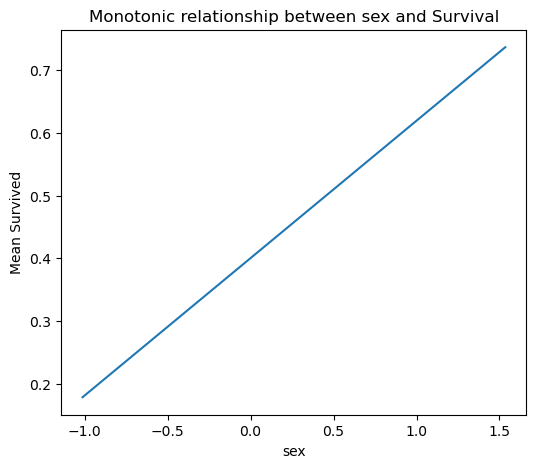

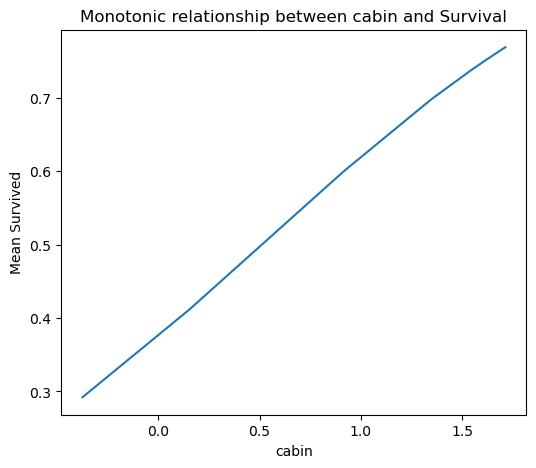

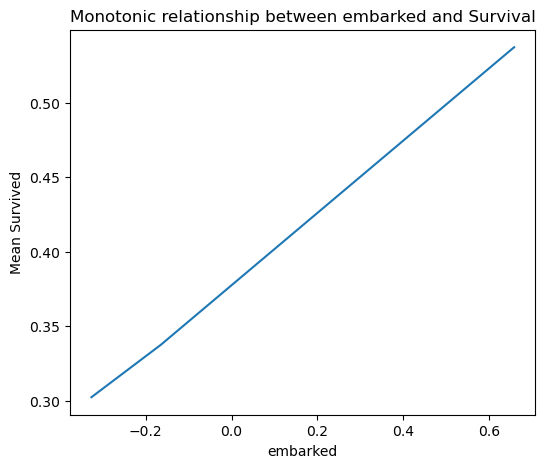

In [40]:
# let's inspect the newly created monotonic relationship
# between the categorical variables and the target

# first in the train set
for var in data.columns:
    if not var == 'survived':
        fig = plt.figure(figsize=(6,5))
        fig = X_train.groupby([var])['survived'].mean().plot()
        fig.set_title('Monotonic relationship between {} and Survival'.format(var))
        fig.set_ylabel('Mean Survived')
        plt.show()

Note the monotonic relationships between the mean target and the categories. In the train set.

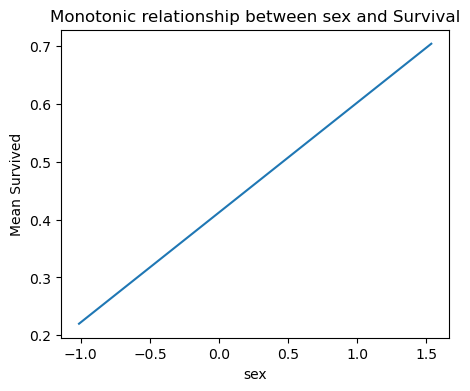

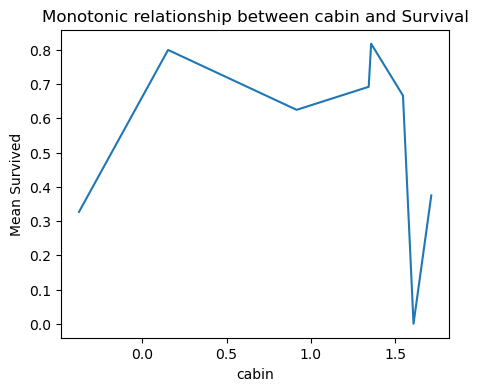

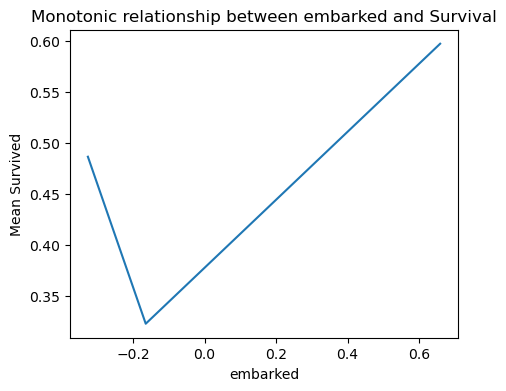

In [39]:
# now in the test set
for var in data.columns:
    if not var == 'survived':
        fig = plt.figure(figsize=(5,4))
        fig = X_test.groupby([var])['survived'].mean().plot()
        fig.set_title('Monotonic relationship between {} and Survival'.format(var))
        fig.set_ylabel('Mean Survived')
        plt.show()

**The monotonic relationship does not hold when encoding the categorical variables in the test set. This could mean that the categories are not informative of the target or the proportion of survivors is not homogeneous between in the categories in the train and test sets.**

**In situations like this, we could try grouping rare labels into a joint category as we will cover later in this section, before applying the Weight of evidence transformation.**

*Note*

**Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.**

**In addition, it will create NA or Inf if any of the 2 terms in the ratio of the WoE formula are 0**